In [1]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
# To do this for a shared folder you need to add the GeoCompassSegmentations folder as a shortcut in MyDrive
GOOGLE_DRIVE_FOLDER = '/content/drive/MyDrive/GeoCompassSegmentations'

In [3]:
# Install Dependencies
!pip install rasterio
!git clone https://github.com/facebookresearch/sam2.git
%cd ./sam2
!pip install -e .
# Install dependencies

Cloning into 'sam2'...
remote: Enumerating objects: 1070, done.
remote: Total 1070 (delta 0), reused 0 (delta 0), pack-reused 1070 (from 1)
Receiving objects: 100% (1070/1070), 128.11 MiB | 24.65 MiB/s, done.
Resolving deltas: 100% (381/381), done.
/content/sam2
Obtaining file:///content/sam2
  error: subprocess-exited-with-error
  
  × pip subprocess to install build dependencies did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Installing build dependencies ... error
error: subprocess-exited-with-error

× pip subprocess to install build dependencies did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


In [11]:
!pip install -e .

Obtaining file:///content/sam2
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 9.9 MB/s eta 0:00:00
  Building editable for SAM-2 (pyproject.toml) ... done
  Created wheel for SAM-2: filename=sam_2-1.0-0.editable-cp312-cp312-linux_x86_64.whl size=13852 sha256=14031b2042e8d01f16527d9a20aa728eb05c4abaa56f2e416f0b245c31efc9f8
  Stored in directory: /tmp/pip-ephem-wheel-cache-2hw4g_q_/wheels/9e/fa/17/14aaeb20d3ca07c58ee93742054d4479f89c243063ce0b61b9
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31527 sha256=9047253339bb985b2cc43dced2f6ab559f31ca07dfa39ca3b2aff7d5c5de7e59
  Stored in directory: /root/.cache/pip/wheels/7c/96/04/4f

In [4]:
import numpy as np
import cv2
import rasterio
import matplotlib.pyplot as plt
import re
import torch
from pathlib import Path

In [5]:
# Unzip images into local machine (content directory)
!rm -rf '/content/data/tiles'
!mkdir '/content/data'
!cp "/content/drive/MyDrive/GeoCompassSegmentations/data-96-rgb/tile_index.csv" '/content/data/tile_index.csv'
!unzip -d '/content/data/' "/content/drive/MyDrive/GeoCompassSegmentations/data-96-rgb/tiles.zip"

Streaming output truncated to the last 5000 lines.
  inflating: /content/data/tiles/tile_label_09341.tif  
  inflating: /content/data/tiles/tile_rgb_01297.png.msk  
 extracting: /content/data/tiles/tile_rgb_04756.png  
  inflating: /content/data/tiles/tile_ms_06563.tif  
 extracting: /content/data/tiles/tile_rgb_09593.png  
  inflating: /content/data/tiles/tile_label_03907.tif  
  inflating: /content/data/tiles/tile_label_08429.tif  
  inflating: /content/data/tiles/tile_rgb_06136.png.msk  
 extracting: /content/data/tiles/tile_rgb_00550.png  
 extracting: /content/data/tiles/tile_rgb_08414.png  
  inflating: /content/data/tiles/tile_label_05415.tif  
  inflating: /content/data/tiles/tile_rgb_06008.png.aux.xml  
  inflating: /content/data/tiles/tile_ms_05878.tif  
  inflating: /content/data/tiles/tile_label_09134.tif  
  inflating: /content/data/tiles/tile_label_07038.tif  
  inflating: /content/data/tiles/tile_rgb_01492.png.msk  
  inflating: /content/data/tiles/tile_rgb_03006.png.msk

In [6]:
!./checkpoints/download_ckpts.sh

--2025-12-10 04:18:24--  https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_tiny.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 99.84.41.33, 99.84.41.79, 99.84.41.129, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|99.84.41.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 156008466 (149M) [application/vnd.snesdev-page-table]
Saving to: ‘sam2.1_hiera_tiny.pt’

sam2.1_hiera_tiny.p 100%[===================>] 148.78M   189MB/s    in 0.8s    

2025-12-10 04:18:25 (189 MB/s) - ‘sam2.1_hiera_tiny.pt’ saved [156008466/156008466]

--2025-12-10 04:18:25--  https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_small.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 99.84.41.33, 99.84.41.79, 99.84.41.129, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|99.84.41.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 184416285 (176M) [application/vn

In [7]:
# Import tortise data libraries
import sys
sys.path.append(GOOGLE_DRIVE_FOLDER + '/Colab_Notebooks/TORTOISE/src')


In [8]:
from tortoise.dataloader import build_dataloaders

train_loader, val_loader, test_loader, image_lists = build_dataloaders(
    "/content/data/tiles",
    "/content/data/tile_index.csv",
    1,
    seed = 42,
    train_ratio = 0.8,
    val_ratio = 0.1,
    test_ratio = None,
    use_rgb=  True,
    use_ms=False,
    num_workers = 0,
)


In [29]:
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
device = "cuda"

# Initialize sam model
sam2_checkpoint = "sam2.1_hiera_small.pt" # path to model weight
finetuned = GOOGLE_DRIVE_FOLDER + "/Colab_Notebooks/models/SAM_model_96_px_cp_3.pth"
model_cfg = "configs/sam2.1/sam2.1_hiera_s.yaml" #  model config
sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device) # load model

# Load your fine-tuned weights
# state = torch.load(finetuned, map_location="cpu")
# sam2_model.load_state_dict(state, strict=False)
# sam2_model.eval()

# Wrap with predictor
predictor = SAM2ImagePredictor(sam2_model)

In [30]:
def bounding_boxes(mask):
    # mask: (B, H, W)
    # Returns: (B, 4) [ymin, xmin, ymax, xmax]

    B, H, W = mask.shape
    # ymin = 0, xmin = 0, ymax = H, xmax = W
    boxes = torch.tensor([0, 0, H, W], dtype=torch.float32, device=mask.device)
    return boxes.unsqueeze(0).repeat(B, 1)

In [31]:
def calculate_bce_dice_metric(pred_logit, gt_mask, valid_mask):
  pred_logit *= valid_mask
  # convert to tensor
  pred_tensor = torch.from_numpy(pred_logit).float().unsqueeze(0)
  gt_tensor = torch.from_numpy(gt_mask).float().unsqueeze(0)

  # bce score
  bce = torch.functional.F.binary_cross_entropy_with_logits(pred_tensor, gt_tensor).item()

  # dice score
  pred_probs = torch.sigmoid(pred_tensor)
  smooth = 1e-6
  intersection = (pred_probs * gt_tensor).sum()
  dice_score = (2.0 * intersection + smooth) / (pred_probs.sum() + gt_tensor.sum() + smooth)
  dice_val = dice_score.item()

  # dice loss (1-dice score)
  dice_loss = 1 - dice_score

  # combine
  combined_loss = bce + dice_loss

  return bce, dice_loss, combined_loss

import matplotlib.pyplot as plt
import seaborn as sns

def plot_metrics(values, metric_name='score', color='blue'):

  plt.figure(figsize=(12, 5))

  # histogram w/ kde
  plt.subplot(1,2,1)
  sns.histplot(values, kde=True, bins=30, color=color, alpha=0.6)
  mean_val = np.mean(values)
  plt.axvline(mean_val, color='red', linestyle='--', label=f"mean:{mean_val:.2f}")
  plt.title(f'Distribution for {metric_name}')
  plt.xlabel(f'{metric_name} value')
  plt.ylabel('count')
  plt.legend()

  # box plot
  plt.subplot(1,2,2)
  sns.boxplot(x=values, color=color)
  plt.title(f'box plot for {metric_name}')
  plt.xlabel(f'{metric_name} score')

  plt.tight_layout()
  plt.show()

In [32]:
import json
import pandas as pd
DATA_FOLDER = GOOGLE_DRIVE_FOLDER + "/data-96-rgb"
tiles_dir = "/content/data/tiles"
imageset_dir = DATA_FOLDER + "/imageset"


def _binary_boundary(mask: torch.Tensor, dilation_pixel=2):
    """
    Extract thin binary boundary from a binary mask using Laplacian.
    mask: (H, W) binary {0,1}
    """
    dilation = dilation_pixel

    lap = torch.tensor([[0, 1, 0],
                        [1,-4, 1],
                        [0, 1, 0]], dtype=torch.float32, device=mask.device).unsqueeze(0).unsqueeze(0)

    # Find boundary pixels
    mask_f = mask.float().unsqueeze(0).unsqueeze(0)
    edges = F.conv2d(mask_f, lap, padding=1).abs()
    edges = (edges > 0).float().squeeze()

    # Dilate boundary
    if dilation > 1:
        kernel = torch.ones((1,1,dilation,dilation), device=mask.device)
        edges = edges.unsqueeze(0).unsqueeze(0)
        dil = F.conv2d(edges, kernel, padding=dilation//2)
        dil = (dil > 0).float().squeeze()
        return dil
    else:
        return edges
def evaluate_metrics(
    logits,
    labels,
    mask,
    metrics=["iou", "dice", "brier"],
    threshold=0.5,
):
    out = {}
    logits = logits.float()
    labels = labels.float()
    mask = mask.float()

    valid = (mask > 0)

    probs = torch.sigmoid(logits)
    probs_valid = probs[valid]
    labels_valid = labels[valid]

    if any(m in metrics for m in ["iou","dice","precision","recall","fpr","fnr"]):
        pred_bin = (probs > threshold)
        label_bin = (labels > 0.5)

        pred_bin = pred_bin & valid
        label_bin = label_bin & valid

        TP = (pred_bin & label_bin).sum().float()
        FP = (pred_bin & ~label_bin).sum().float()
        FN = (~pred_bin & label_bin).sum().float()
        TN = (~pred_bin & ~label_bin & valid).sum().float()

        if "iou" in metrics:
            out["iou"] = (TP / (TP + FP + FN + 1e-6)).item()

        if "dice" in metrics:
            out["dice"] = (2 * TP / (2 * TP + FP + FN + 1e-6)).item()

        if "precision" in metrics:
            out["precision"] = (TP / (TP + FP + 1e-6)).item()

        if "recall" in metrics:
            out["recall"] = (TP / (TP + FN + 1e-6)).item()

        if "fpr" in metrics:
            out["fpr"] = (FP / (FP + TN + 1e-6)).item()

        if "fnr" in metrics:
            out["fnr"] = (FN / (FN + TP + 1e-6)).item()

    if "brier" in metrics:
        out["brier"] = ((probs_valid - labels_valid)**2).mean().item()

    if "pixelwise_entropy" in metrics:
        p = probs.clamp(1e-6, 1 - 1e-6)
        entropy = -(p * torch.log(p) + (1 - p) * torch.log(1 - p))
        out["pixelwise_entropy"] = entropy * mask

    if "boundary_iou" in metrics:
        pred_bin = (probs > threshold) & valid
        label_bin = (labels > 0.5) & valid

        # boundary extraction
        b_pred = _binary_boundary(pred_bin.float())
        b_label = _binary_boundary(label_bin.float())

        # intersection and union
        inter = (b_pred * b_label).sum().float()
        union = (b_pred + b_label).clamp(max=1).sum().float()

        out["boundary_iou"] = (inter / (union + 1e-6)).item()

    return out

import pandas as pd

def get_bounding_box(mask):
  rows, cols = np.where(mask>0)
  if len(rows) == 0:
        return None
  return np.array([np.min(cols), np.min(rows), np.max(cols), np.max(rows)])

def ensemble_inference(predictor, image_id: str, use_rgb = True, threshold = 0.5):
    """Get the tears from the image_id

    Args:
        image_id (str): _description_
        use_rgb (bool, optional): _description_. Defaults to False.

    Returns:
        _type_: _description_
    """
    image_id_dir = imageset_dir +"/" + image_id

    meta_file = image_id_dir + "/meta.json"

    if use_rgb:
        image = image_id_dir + "/rgb.png"
    else:
        image = image_id_dir + "/ms.tif"

    with open(meta_file, "r") as f:
        meta = json.load(f)

    height = int(meta["height"])
    width = int(meta["width"])
    tile_size = 96


    tiles = meta.get("valid_tiles", [])

    bsz = len(tiles)
    channels = 3 if use_rgb else 13

    batch = torch.zeros((bsz, channels, tile_size, tile_size), dtype=torch.float32)
    batch_masks = torch.zeros((bsz, 1, tile_size, tile_size), dtype=torch.float32)
    positions: list[tuple[int, int]] = []

    for idx, tile in enumerate(tiles):
        tid = int(tile["tile_id"])
        positions.append((int(tile["h0"]), int(tile["w0"])))

        tile_path = tiles_dir +"/"+ (f"tile_rgb_{tid:05d}.png" if use_rgb else f"tile_ms_{tid:05d}.tif")
        label_path = tiles_dir + "/" + f"tile_label_{tid:05d}.tif"

        with rasterio.open(tile_path) as src:
            arr = src.read().astype(np.float32)
        arr /= 255.0 if use_rgb else 10000.0

        with rasterio.open(label_path) as src:
            mask_arr = src.dataset_mask().astype(np.float32) / 255.0

        mask_tensor = torch.from_numpy(mask_arr)
        batch_masks[idx, 0] = mask_tensor
        batch[idx] = torch.from_numpy(arr) * mask_tensor.unsqueeze(0)
    probs = torch.zeros((len(batch), tile_size, tile_size))
    with torch.no_grad():
        # Iterate through images in the batch
        for i in range(len(batch)):
            img_np = batch[i].cpu().numpy().transpose(1, 2, 0)

            # Denormalize if necessary
            if img_np.max() <= 1.0:
                img_np = (img_np * 255).astype(np.uint8)
            else:
                img_np = img_np.astype(np.uint8)

            predictor.set_image(img_np)

            # Prepare Prompt
            mask_np = batch_masks[i, 0].cpu().numpy()
            if mask_np.ndim == 3:
                mask_np = mask_np[0]

            mask_np = (mask_np > 0).astype(np.uint8)
            box_prompt = get_bounding_box(mask_np)

            if box_prompt is None:
                continue

            # Predict
            masks, scores, _ = predictor.predict(
                box=box_prompt,
                multimask_output=True
            )

            # Calculate IOU
            best_idx = np.argmax(scores)
            pred_mask = torch.from_numpy((masks[best_idx] > 0.0).astype(np.uint8))

            probs[i] = pred_mask * batch_masks[i,0].cpu()

    probs = probs.squeeze(1).cpu()
    tile_masks = batch_masks.squeeze(1)

    pred_sum = torch.zeros((height, width), dtype=torch.float32)
    weight_sum = torch.zeros((height, width), dtype=torch.float32)

    for idx, (h0, w0) in enumerate(positions):
        h1, w1 = h0 + tile_size, w0 + tile_size
        pred_sum[h0:h1, w0:w1] += probs[idx] * tile_masks[idx]
        weight_sum[h0:h1, w0:w1] += tile_masks[idx]

    pred_full = pred_sum / (weight_sum + 1e-6)

    with rasterio.open(image_id_dir + "/label.tif") as src:
        label_full = torch.from_numpy(src.read(1).astype(np.float32)) / 65535.0
        label_mask = torch.from_numpy(src.dataset_mask().astype(np.float32)) / 255.0
    m = evaluate_metrics(
            logits=pred_full,
            labels=label_full,
            mask=label_mask,
            metrics=["iou","dice","precision","recall","fpr","fnr"],
        )

    return m

metric_rows = []
for image_id in image_lists[2]:
    m = ensemble_inference(predictor, image_id, use_rgb = True, threshold = 0.5)
    print(m['iou'])
    metric_rows.append(m)

df = pd.DataFrame(metric_rows, index=image_lists[2])
print(df.mean())

0.41210490465164185
0.47593173384666443
0.2998626232147217
0.13588201999664307
0.2379496991634369
0.7570967674255371
0.12377268075942993
0.17544031143188477
0.14315922558307648
0.439409077167511
0.1014135405421257
0.25120237469673157
0.08021356165409088
0.19222211837768555
0.23369379341602325
0.36348244547843933
0.4650968313217163
0.9163937568664551
0.22956570982933044
0.18820598721504211
0.201085165143013
0.29777100682258606
0.1333734393119812
0.062253452837467194
0.8233077526092529
0.21916429698467255
0.24119174480438232
0.08812577277421951
0.3311034142971039
0.07541108131408691
0.0733642652630806
0.5084834694862366
0.0127372145652771
0.06492438912391663
0.054913707077503204
0.1347791850566864
0.3501315414905548
0.14396695792675018
0.05880170688033104
0.16569122672080994
0.15410208702087402
0.178434818983078
0.09843901544809341
0.20874163508415222
0.10286225378513336
0.373390257358551
0.22698450088500977
0.180795818567276
0.07988904416561127
iou          0.242170
dice         0.35748

In [33]:
plot_metrics(test_ious, metric_name="IoU Score", color='blue')

NameError: name 'test_ious' is not defined

In [ ]:
def calculate_iou(pred_labels, gt_labels, valid_mask):
  # cal IOU between predicted actual mask
  pred_labels *= valid_mask
  pred_flat = pred_labels.flatten().astype(bool)
  gt_flat = gt_labels.flatten().astype(bool)

  intersection = np.logical_and(pred_flat, gt_flat).sum()
  union = np.logical_or(pred_flat, gt_flat).sum()

  if union == 0:
    if intersection == 0:
      return 0
    else:
      return 1
  return intersection / union

def get_areas(pred_labels, gt_labels, valid_mask):
  pred_labels *= valid_mask
  pred_flat = pred_labels.flatten().astype(bool)
  gt_flat = gt_labels.flatten().astype(bool)
  return pred_flat.sum(), gt_flat.sum()

def get_bounding_box(mask):

  rows, cols = np.where(mask>0)
  if len(rows) == 0:
        return None
  return np.array([np.min(cols), np.min(rows), np.max(cols), np.max(rows)])

def evaluate_sam2(loader, predictor, max_examples=None):

    iou_scores = []
    bce_losses = []
    dice_losses = []
    area_ratios = []
    count = 0
    total_pred_area = 0
    total_gt_area = 0

    # Iterate through batches
    for batch_idx, batch_data in enumerate(loader):
        # Stop if we have reached the limit
        if max_examples is not None and count >= max_examples:
            break

        # Adjust unpacking based on your dataloader structure
        images = batch_data['rgb']
        gt_masks = batch_data['label']
        valid_masks = batch_data['mask']


        # Iterate through images in the batch
        for i in range(len(images)):
            # Check limit again inside the batch loop
            if max_examples is not None and count >= max_examples:
                break

            # A. Preprocess Image (C,H,W -> H,W,C and uint8 0-255)
            img_np = images[i].cpu().numpy().transpose(1, 2, 0)

            # Denormalize if necessary
            if img_np.max() <= 1.0:
                img_np = (img_np * 255).astype(np.uint8)
            else:
                img_np = img_np.astype(np.uint8)

            predictor.set_image(img_np)

            # B. Prepare Prompt
            gt_mask_np = gt_masks[i].cpu().numpy()
            if gt_mask_np.ndim == 3:
                gt_mask_np = gt_mask_np[0]

            valid_mask_np = valid_masks[i].cpu().numpy().astype(np.uint8)

            gt_mask_np = (gt_mask_np > 0).astype(np.uint8)
            box_prompt = get_bounding_box(gt_mask_np)

            if box_prompt is None:
                continue

            # C. Predict
            masks, scores, _ = predictor.predict(
                box=box_prompt,
                multimask_output=True
            )

            # D. Calculate IoU
            best_idx = np.argmax(scores)
            pred_mask = (masks[best_idx] > 0.0).astype(np.uint8)
            # Calculate IoU
            iou = calculate_iou(pred_mask, gt_mask_np, valid_mask_np)
            iou_scores.append(iou)

            # How far off area we
            pred_area, gt_area = get_areas(pred_mask, gt_mask_np, valid_mask_np)
            area_ratio = pred_area/gt_area
            area_ratios.append(area_ratio)

            total_pred_area += pred_area
            total_gt_area += gt_area

            # bce + dice loss
            bce, dice_loss, combined = calculate_bce_dice_metric(
                pred_mask,
                gt_mask_np,
                valid_mask_np
            )
            bce_losses.append(bce)
            dice_losses.append(dice_loss)

            count += 1
            if count % 500 == 0:
                print(f"Processed {count} images...")

    # Report Results
    if iou_scores:
        print(f"\nEvaluation Complete.")
        print(f"Mean IoU: {np.mean(iou_scores):.4f}")
        print(f"Mean BCE: {np.mean(bce_losses):.4f}")
        print(f"Mean Dice Loss: {np.mean(dice_losses):.4f}")
    else:
        print("No valid samples evaluated.")

    total_area_ratio = total_pred_area/total_gt_area
    print(f"Total area ratio: {total_area_ratio}")

    return iou_scores, bce_losses, dice_losses, area_ratios


0.5338150289017342


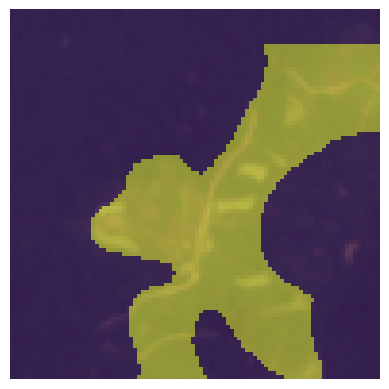

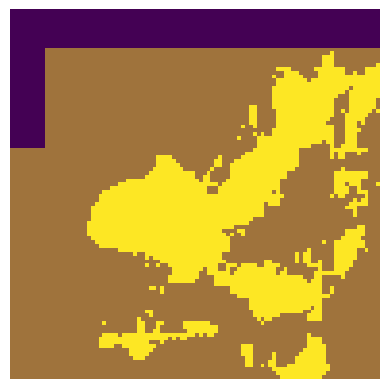

In [ ]:
for i,batch in enumerate(test_loader):
    idx = 26
    if i < idx:
        continue
    elif i == idx+1:
        break

    # A. Preprocess Image (C,H,W -> H,W,C and uint8 0-255)
    img_np = batch["rgb"][0].cpu().numpy().transpose(1, 2, 0)

    # Denormalize if necessary
    if img_np.max() <= 1.0:
        img_np = (img_np * 255).astype(np.uint8)
    else:
        img_np = img_np.astype(np.uint8)

    predictor.set_image(img_np)

    # B. Prepare Prompt
    gt_mask_np = batch["label"][0].cpu().numpy()
    if gt_mask_np.ndim == 3:
        gt_mask_np = gt_mask_np[0]

    valid_mask_np = batch["mask"][0].cpu().numpy().astype(np.uint8)

    gt_mask_np = (gt_mask_np > 0).astype(np.uint8)
    box_prompt = get_bounding_box(gt_mask_np)

    if box_prompt is None:
        continue

    # C. Predict
    masks, scores, _ = predictor.predict(
        box=box_prompt,
        multimask_output=True
    )

    # D. Calculate IoU
    best_idx = np.argmax(scores)
    pred_mask = (masks[best_idx] > 0.0).astype(np.uint8)
    # Calculate IoU
    iou = calculate_iou(pred_mask, gt_mask_np, valid_mask_np)
    print(iou)
    # bce + dice loss
    bce, dice_loss, combined = calculate_bce_dice_metric(
        masks[best_idx],
        gt_mask_np,
        valid_mask_np
    )

    # Show ground truth
    plt.imshow(img_np / 255.0)
    plt.imshow(gt_mask_np, alpha=0.5)
    plt.axis("off")
    plt.show()
    # Show prediction
    plt.imshow(pred_mask)  # overlay
    plt.imshow(valid_mask_np, alpha=0.5)
    plt.axis("off")
    plt.show()


In [ ]:
test_ious, test_bce, test_dice, test_areas = evaluate_sam2(test_loader, predictor)

Processed 500 images...
Processed 1000 images...

Evaluation Complete.
Mean IoU: 0.6936
Mean BCE: 0.6367
Mean Dice Loss: 0.6372
Total area ratio: 0.7887398977403925


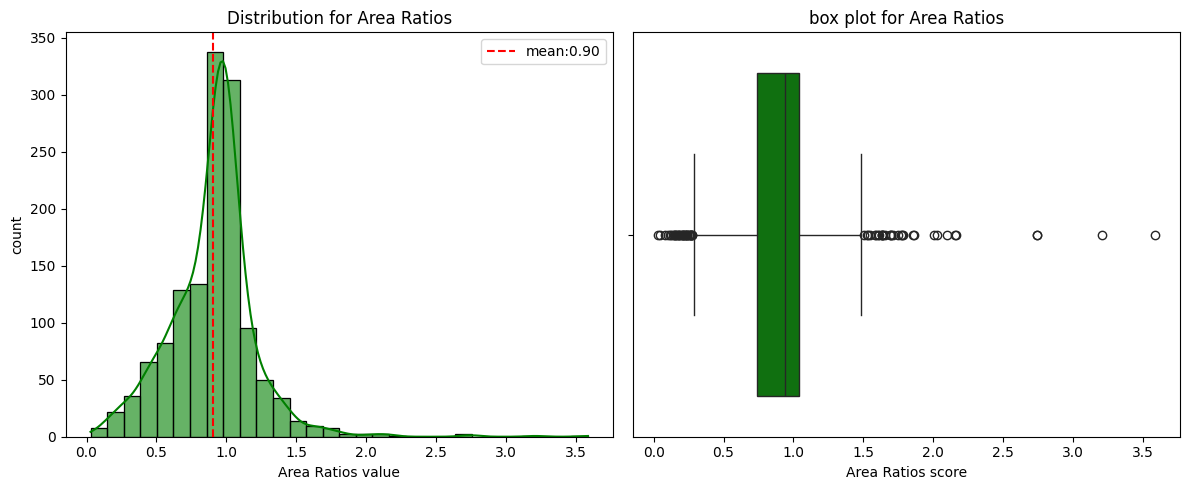

In [ ]:
plot_metrics(test_areas, metric_name="Area Ratios", color='green')

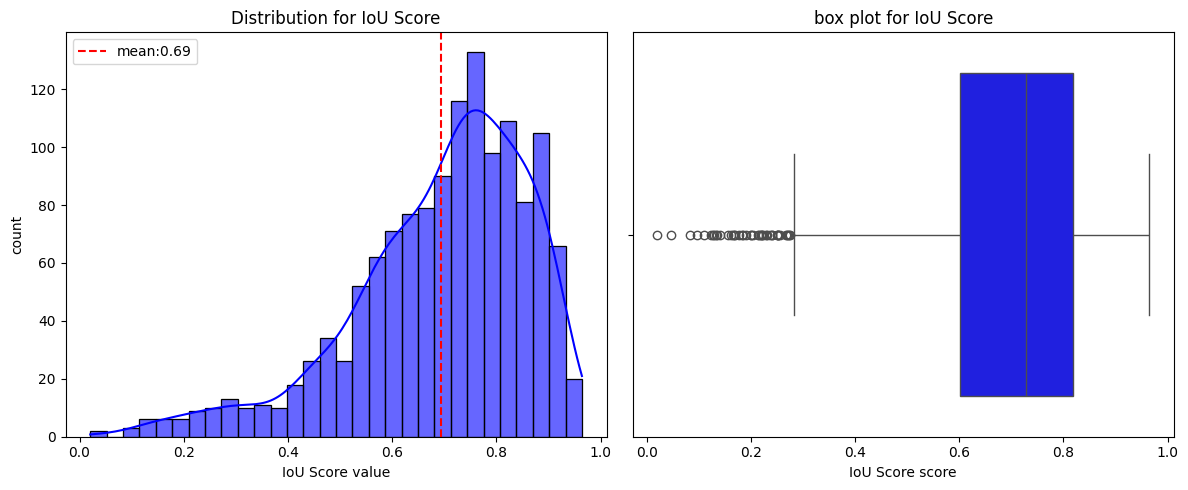

In [ ]:
plot_metrics(test_ious, metric_name="IoU Score", color='blue')

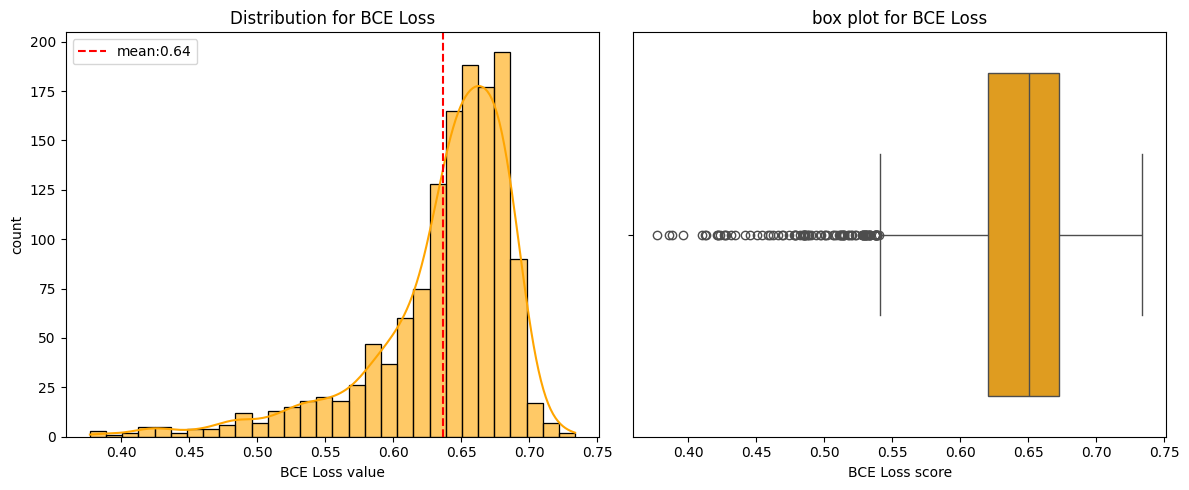

In [ ]:
plot_metrics(test_bce, metric_name="BCE Loss", color='orange')